## Validated boundaries to government unit incident density comparison

The backing theory for this notebook is proving that we will be able to use the highest-density (fire count vs government unit area) government unit to determine a department's boundary for departments that do not have boundaries.

In [1]:
import psycopg2
from psycopg2.extras import RealDictCursor
import pandas as pd
# import geopandas as gpd
# from shapely import wkb
# from shapely.geometry import mapping as to_geojson
# import folium

pd.options.display.max_columns = None
pd.options.display.max_rows = None
#pd.set_option('display.float_format', lambda x: '%.3f' % x)

%matplotlib inline

/Users/joe/.pyenv/versions/2.7.14/envs/firecares-data/lib/python2.7/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [2]:
conn = psycopg2.connect('service=firecares')
nfirs = psycopg2.connect('service=nfirs')

### DB migration/setup

In [9]:
# Create materialized view of all usgs govt units in FireCARES

q = """
create materialized view if not exists usgs_governmentunits as
(
    select id, county_name as name, 'countyorequivalent' as source, geom from usgs_countyorequivalent where geom is not null
    union
    select id, place_name as name, 'incorporatedplace' as source, geom from usgs_incorporatedplace where geom is not null
    union
    select id, minorcivildivision_name as name, 'minorcivildivision' as source, geom from usgs_minorcivildivision where geom is not null
    union
    select id, name, 'nativeamericanarea' as source, geom  from usgs_nativeamericanarea where geom is not null
    union
    select id, name, 'reserve' as source, geom  from usgs_reserve where geom is not null
    union
    select id, state_name as name, 'stateorterritoryhigh' as source, geom from usgs_stateorterritoryhigh where geom is not null
    union
    select id, place_name as name, 'unincorporatedplace' as source, geom from usgs_unincorporatedplace where geom is not null
);

create unique index on usgs_governmentunits (id, source);
create index on usgs_governmentunits using gist (geom);
"""
    
with conn.cursor() as c:
    c.execute(q)
    
conn.commit()

In [ ]:
# Link remote firecares usgs_governmentunits view to nfirs-local usgs_government units

q = """
create foreign table usgs_governmentunits (id integer, name character varying(120), source text, geom geometry)
server firecares
options (table_name 'usgs_governmentunits');
"""

with nfirs.cursor() as c:
    c.execute(q)
    
nfirs.commit()

In [11]:
# Old nfirs.firestation_firedepartment foreign table columns needed to be synced

q = """
alter foreign TABLE firestation_firedepartment add column archived boolean NOT NULL;
alter foreign TABLE firestation_firedepartment add column domain_name character varying(255);
alter foreign TABLE firestation_firedepartment add column owned_tracts_geom public.geometry(MultiPolygon,4326);
alter foreign TABLE firestation_firedepartment add column display_metrics boolean NOT NULL;
alter foreign TABLE firestation_firedepartment add column boundary_verified boolean NOT NULL;
alter foreign TABLE firestation_firedepartment add column cfai_accredited boolean NOT NULL;
alter foreign TABLE firestation_firedepartment add column ems_transport boolean NOT NULL;
alter foreign TABLE firestation_firedepartment add column staffing_verified boolean NOT NULL;
alter foreign TABLE firestation_firedepartment add column stations_verified boolean NOT NULL;
alter foreign TABLE firestation_firedepartment add column census_override boolean NOT NULL;
alter foreign TABLE firestation_firedepartment add column additional_fdids character varying(255);
"""

with nfirs.cursor() as c:
    c.execute(q)
nfirs.commit()

In [12]:
q = """
create foreign table if not exists firecares_core_address (id integer NOT NULL,
    address_line1 character varying(100) NOT NULL,
    address_line2 character varying(100),
    city character varying(50) NOT NULL,
    state_province character varying(40) NOT NULL,
    postal_code character varying(10) NOT NULL,
    geom public.geometry(Point,4326),
    geocode_results text,
    country_id character varying(2) NOT NULL)
server firecares
options (table_name 'firecares_core_address');
"""

with nfirs.cursor() as c:
    c.execute(q)
nfirs.commit()

### Processing

In [5]:
q = """
select id, fdid, state, name
from firestation_firedepartment
where boundary_verified = true;
"""

with nfirs.cursor(cursor_factory=RealDictCursor) as c:
    c.execute(q)
    fds = c.fetchall()

In [29]:
q = """
with fires as (select * from joint_buildingfires
    inner join joint_incidentaddress
    using (fdid, inc_no, inc_date, state, exp_no)
    where state = %(state)s and fdid = %(fdid)s
),
govt_units as (
    select gu.name, gu.source, gu.id, gu.geom, fd.id as fc_id, fd.geom as fd_geom, ST_Distance(addr.geom, ST_Centroid(gu.geom)) as distance_to_headquarters
    from firestation_firedepartment fd
    inner join firecares_core_address addr
        on addr.id = fd.headquarters_address_id
    join usgs_governmentunits gu
    on ST_Intersects(ST_Buffer(addr.geom, 0.05), gu.geom)
    where 
        fd.fdid = %(fdid)s and fd.state = %(state)s and source != 'stateorterritoryhigh'
    )
select gu.fc_id, count(fires) / ST_Area(gu.geom) as density, count(fires), ST_Area(ST_SymDifference(gu.fd_geom, gu.geom)) / ST_Area(gu.fd_geom) as percent_difference_to_verified_boundary, ST_Area(gu.geom), gu.distance_to_headquarters, gu.name, gu.id, gu.source from fires
inner join govt_units gu
on ST_Intersects(fires.geom, gu.geom)
group by gu.name, gu.id, gu.geom, gu.source, gu.distance_to_headquarters, gu.fd_geom, gu.fc_id
order by ST_Area(gu.geom) / count(fires) asc;
"""

for fd in fds:
    with nfirs.cursor(cursor_factory=RealDictCursor) as c:
        print 'Analyzing: {} (id: {} fdid: {} {})'.format(fd['name'], fd['id'], fd['fdid'], fd['state'])
        c.execute(q, dict(fdid=fd['fdid'], state=fd['state']))
        items = c.fetchall()
        df = pd.DataFrame(items)
        df.to_csv('./boundary-analysis-{}.csv'.format(fd['id']))

Analyzing: Southington Fire Department (id: 95681 fdid: 02230 CT)


### Results

In [17]:
from glob import glob

In [18]:
df = None
for f in glob("*.csv"):
    if df is not None:
        df = df.append(pd.read_csv(f))
    else:
        df = pd.read_csv(f)

In [27]:
df.rename(columns={'Unnamed: 0': 'rank'}, inplace=True)
selected_government_units = df[df['rank'] == 0].set_index('fc_id')
total_validated_department_count = len(selected_government_units)
perfect_fits = len(selected_government_units[selected_government_units['percent_difference_to_verified_boundary'] == 0])

In [28]:
print 'Perfect fits: {}/{} ({:.2%})'.format(perfect_fits, total_validated_department_count, float(perfect_fits) / total_validated_department_count)
print 'Machine-selected government unit area difference mean: {:.2%}'.format(df[df['rank'] == 0].percent_difference_to_verified_boundary.mean())

Perfect fits: 25/71 (35.21%)
Machine-selected government unit area difference mean: 40.29%


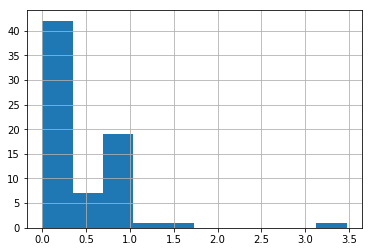

In [32]:
selected_government_units['percent_difference_to_verified_boundary'].hist()

In [33]:
selected_government_units

,rank,count,density,distance_to_headquarters,id,name,percent_difference_to_verified_boundary,source,st_area
fc_id,,,,,,,,,
78801,0,585,99716.978516,0.011408,11589,Corsicana,0.000000e+00,incorporatedplace,0.005867
85026,0,3,22941.311075,0.007315,5560,Isleton,1.959799e-01,incorporatedplace,0.000131
78578,0,372,19210.181569,0.018676,18456,Concord,0.000000e+00,incorporatedplace,0.019365
77887,0,492,411712.758527,0.010133,2042,Somerville,0.000000e+00,minorcivildivision,0.001195
83442,0,387,41660.471964,0.029491,43286,Hamden,0.000000e+00,minorcivildivision,0.009289
81727,0,107,65950.416117,0.076698,6626,Cumming,9.740965e-01,incorporatedplace,0.001622
81531,0,29,1254.014221,0.068297,7956,Palm Coast,8.129361e-01,incorporatedplace,0.023126
78792,0,3067,36616.371421,0.094370,45799,Corpus Christi,9.758430e-01,minorcivildivision,0.083760
89555,0,121,35694.222690,0.017323,13985,Murray,0.000000e+00,incorporatedplace,0.003390


In [34]:
df

,rank,count,density,distance_to_headquarters,fc_id,id,name,percent_difference_to_verified_boundary,source,st_area
0,0,585,99716.978516,0.011408,78801,11589,Corsicana,0.000000e+00,incorporatedplace,0.005867
1,1,617,6956.982835,0.049155,78801,40009,Corsicana,1.411741e+01,minorcivildivision,0.088688
2,2,620,2308.610455,0.046837,78801,2605,Navarro,4.477773e+01,countyorequivalent,0.268560
0,0,3,22941.311075,0.007315,85026,5560,Isleton,1.959799e-01,incorporatedplace,0.000131
1,1,3,86.923032,0.015528,85026,36080,Isleton,2.839006e+02,minorcivildivision,0.034513
2,2,3,11.288303,0.393362,85026,2521,Sacramento,2.192813e+03,countyorequivalent,0.265762
0,0,372,19210.181569,0.018676,78578,18456,Concord,0.000000e+00,incorporatedplace,0.019365
1,1,372,19210.181569,0.018676,78578,30145,Concord,0.000000e+00,minorcivildivision,0.019365
2,2,373,1357.456627,0.156079,78578,1813,Merrimack,1.318964e+01,countyorequivalent,0.274779
0,0,492,411712.758527,0.010133,77887,2042,Somerville,0.000000e+00,minorcivildivision,0.001195
